In [2]:
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
from pandas_datareader import data as pdr
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def get_data(ticker, start, end):
    data = yf.download(ticker, start, end)
    close_price = data['Close']
    returns = close_price.pct_change()
    mean_returns = returns.mean()
    cov_mat = returns.cov()
    # Correlation is normalized covariance by dividing it by the product of stdev of the two variables
    return mean_returns, cov_mat

In [4]:
stocklist = ['BRMS', 'MAPA', 'BBRI', 'DEWA', 'GOTO']
tickers = [stock + '.JK' for stock in stocklist]
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=300)

mean_returns, cov_mat = get_data(tickers, start_date, end_date)

[*********************100%***********************]  5 of 5 completed


<Axes: xlabel='Ticker', ylabel='Ticker'>

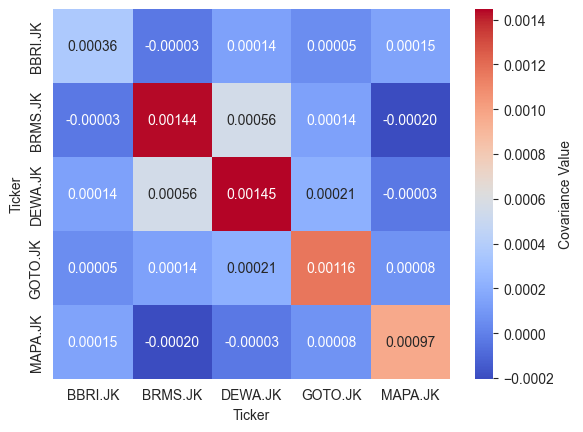

In [5]:
sns.heatmap(cov_mat, annot=True, cmap='coolwarm', fmt=".5f", cbar_kws={'label': 'Covariance Value'})

In [6]:
# Random weight on portfolio
weights = np.random.random(len(mean_returns))
weights /= np.sum(weights)

n_sims = 100
T = 100
# T is trading days

# matrix to hold average returns
mean_mat = np.full(shape=(T, len(mean_returns)), fill_value=mean_returns)

mean_mat_transpose = mean_mat.T # shape (T,Stocks)
portfolio_sims = np.full(shape=(T, n_sims), fill_value=0.0) # Store simulated portfolio

initial_portfolio = 10_000

for n in range(0, 100):
    Z = np.random.normal(size=(T, len(weights)))
    # Independent standard normal random variables
    L = np.linalg.cholesky(cov_mat) # lower triangular matrix
    daily_returns = mean_mat_transpose + np.inner(L, Z) 
    # pairwise dot product, transforms independent random normals into correlated random variables where correlation structure is consitent with covariance matrix
    portfolio_sims[:, n] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_portfolio

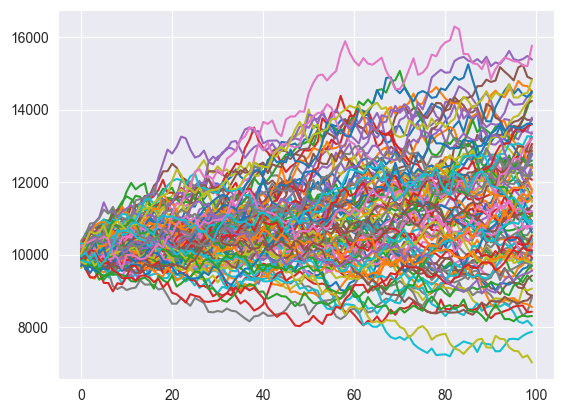

In [7]:
plt.plot(portfolio_sims)
plt.show()

* VaR represents the maximum loss expected at a given confidence level (1-alpha)
* CVaR represents average loss given that losses exceed the VaR threshold

In [11]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")


portResults = pd.Series(portfolio_sims[-1,:])

VaR = initial_portfolio - mcVaR(portResults, alpha=5)
CVaR = initial_portfolio - mcCVaR(portResults, alpha=5)
print('VaR:', VaR, 'cVaR:', CVaR, """

Interpretation
There is a 5% chance that the portfolio will lose at least 722$ over the simulated period. Equivalently, the portfolio’s final value in the 5% worst-case scenarios would be $10,000 - $722.25 = $9,277.75.

In the 5% worst-case scenarios, the average loss is $1,817.87.
The portfolio’s expected final value in those cases would be $10,000 - $1,817.87 = $8,182.13.
"""
      )

VaR: 1455.9571367817134 cVaR: 2068.4143558363985 

Interpretation
There is a 5% chance that the portfolio will lose at least 722$ over the simulated period. Equivalently, the portfolio’s final value in the 5% worst-case scenarios would be $10,000 - $722.25 = $9,277.75.

In the 5% worst-case scenarios, the average loss is $1,817.87.
The portfolio’s expected final value in those cases would be $10,000 - $1,817.87 = $8,182.13.



* High variance implies that the estimator is less reliable as the outcomes are more dispersed
* Low variance makes the estimator more reliable and narrows the confidence intervals, increasing trust in the estimate, if the variance is large


## Valuation by Simulation

The risk-neutral pricing methodology tells us that:
- value of an option = risk-neutral expectation of its discounted payoff

We can estimate this expectation by computing the average of a large number of discounted payoffs. For a particular simulation $i$:

$\Large C_{0,i} = \exp (-\int^{T}_{0}r_s ds) C_{T,i} = \exp (-rT) C_{T,i}$

Now if we repeat the simulation $M$ times, we can average the outcomes.
$\Large \hat{C_0} = \frac{1}{M}\sum^{M}_{i=1} C_{0,i}$

### Standard Error $SE(\hat{C_0})$

$\hat{C_0}$ is an estimate of the true value of the option $C_0$ with error due to the fact we are taking an average of randomly generated samples, and so therefore the calculation is itself random. A measure of this error is the standard deviation of $\hat{C_0}$ called the standard error. This can be estimated as the standard deviation of $C_{0,i}$ divided by the number of samples $M$.

$\Large SE(\hat{C_0}) = \frac{\sigma(C_{0,i}) }{\sqrt{M}}$

$\Large \sigma(C_{0,i}) = \sqrt{ \frac{1}{M-1} \sum^{M}_{i=1} (C_{0,i} - \hat{C_0})^2 } $


Here we have constant interest rate so the discount factor is $\exp(-rT)$, and the stock dynamics are modelled with Geometric Brownian Motion (GBM).

$\large dS_t = rS_tdt+\sigma S_tdW_t$

Let's simulate this GBM process by simulating variables of the natural logarithm process of the stock price $x_t = ln(S_t)$, which is normally distributed. For the dynamics of the natural logarithm process of stock prices under GBM model you need to use Ito's calculus. Please watch the video on my YouTube channell 'Stochastic Calculus for Quants | Understanding Geometric Brownian Motion using Itô Calculus' if you would like to understand why the SDE changes in this case.

$\large dx_t = \nu dt+\sigma dz_t ,  \nu = r - \frac{1}{2} \sigma ^ 2$

We can then discretize the Stochastic Differential Equation (SDE) by changing the infinitesimals $dx, dt, dz$ into small steps $\Delta x, \Delta t, \Delta z$.

$\large \Delta x = \nu  \Delta t+\sigma \Delta z$

This is the exact solution to the SDE and involves no approximation.

$\large x_{t+\Delta t} = x_{t} + \nu (\Delta t)+\sigma (z_{t+\Delta t}- z_t)$

In terms of the stock price S, we have:

$\large S_{t+\Delta t} = S_{t} \exp( \nu \Delta t + \sigma (z_{t+\Delta t}- z_t) )$

Where $(z_{t+\Delta t}- z_t) \sim N(0,\Delta t) \sim \sqrt{\Delta t} N(0,1) \sim \sqrt{\Delta t} \epsilon_i$

## General Control Variate Equation

For J control variates we have:

$ \Large C_0\exp(rT) = C_T - \sum^J_{i=j}\beta_j cv_j + \eta$

where
- $\beta_j$ are factors to account for the "true" linear relationship between the option pay-off and the control variate $cv_j$
- $\eta$ accounts for errors:
    - discrete rebalancing
    - approximations in hedge sensitivities (calc. delta / gamma)
    
    
Option price as the sum of the linear relationships with J control variates
    
$ \large C_T =\beta_0 + \sum^J_{i=j}\beta_j cv_j + \eta$

where $\beta_0 = C_0\exp(rT)$ is the forward price of the option

If we perform M simulations at discrete time intervals N we can regard the pay-offs and control variates as samples of the linear relationship with some noise. We can estimate the true relationship between control variates and option pay-offs with least-squares regression:

$\beta = (X'X)^{-1}X'Y$

We don't want biased estimates of $\beta_j$ so these should be precomputed by least-squares regression to establish the relationship between types of control variates and options first. These estaimates of $\beta_j$ values can then be used for $cv_j$ for pricing any option.  

In [16]:
import numpy as np

# Option Parameters
initial_stock_price = 101.15    # Current stock price (S)
strike_price = 98.01            # Strike price (K)
volatility = 0.0991             # Volatility (σ)
risk_free_rate = 0.015          # Risk-free rate (r)
num_time_steps = 10             # Number of time steps (N)
num_simulations = 1000          # Number of Monte Carlo simulations (M)
time_to_maturity = 60 / 365     # Time to maturity in years (T)

# Precompute Constants
time_step = time_to_maturity / num_time_steps          # Length of each time step (Δt)
drift = (risk_free_rate - 0.5 * volatility**2) * time_step  # Drift term (νΔt)
diffusion = volatility * np.sqrt(time_step)           # Diffusion term (σ√Δt)
log_initial_price = np.log(initial_stock_price)       # Logarithm of initial stock price (ln(S))

# Initialize Accumulators for Payoff and Variance
total_payoff = 0
total_payoff_squared = 0

# Function to Simulate One Log-Price Path
def simulate_log_price_path(log_price, drift, diffusion, num_steps):
    """Simulates the final log price using geometric Brownian motion."""
    for _ in range(num_steps):
        random_shock = np.random.normal()
        log_price += drift + diffusion * random_shock
    return log_price

# Monte Carlo Simulation
for _ in range(num_simulations):
    # Simulate the final log price of the stock
    final_log_price = simulate_log_price_path(log_initial_price, drift, diffusion, num_time_steps)
    final_price = np.exp(final_log_price)  # Convert log price to normal price

    # Calculate the option payoff
    payoff = max(0, final_price - strike_price)

    # Accumulate results for mean and variance calculations
    total_payoff += payoff
    total_payoff_squared += payoff**2

discount_factor = np.exp(-risk_free_rate * time_to_maturity)
option_value = discount_factor * total_payoff / num_simulations  # Present value of expected payoff
variance = (total_payoff_squared - (total_payoff**2) / num_simulations) * discount_factor**2 / (num_simulations - 1)
standard_error = np.sqrt(variance) / np.sqrt(num_simulations)

# Display Results
print(f"Call option value: ${option_value:.2f}")
print(f"Standard error: +/- ${standard_error:.2f}")

Call option value: $3.98
Standard error: +/- $0.11


## Antithetic Variates

Let's write an option on asset $S_1$ and another option on asset $S_2$ that is perfectly negatively correlated with $S_1$ and which currently has the same price. $S_1$ and $S_2$ satisfy the following Stochastic Differential Equations:

$\large dS_{1,t} = rdS_{1,t}dt+\sigma dS_{1,t}dz_t$

$\large dS_{2,t} = rdS_{2,t}dt-\sigma dS_{2,t}dz_t$

Since the price and volatility of the two assets are identical, so is the value of these two options. However, the variance of a portfolio pay-off containing both of these contracts is much less than the variance of the pay-off of each individual contract. In essence we are removing the large spike in probability distribution of a single contract pay-off. i.e. Basic Intuition: when one option pays out, the other does not.

To implement an antithetic variate we create a hypothetical asset which is perfectly negatively correlated with the original asset. Implementation is very simple, and if we consider the example of the European Call Option. Our simulated pay-offs are under the following $S_t$ dynamics:

$\large S_{t+\Delta t} = S_{t} \exp( \nu \Delta t + \sigma (z_{t+\Delta t}- z_t) )$

Where $(z_{t+\Delta t}- z_t) \sim N(0,\Delta t) \sim \sqrt{\Delta t} N(0,1) \sim \sqrt{\Delta t} \epsilon_i$

### Contract Simulation

- $\large C_{T,i} = max(0, S \exp( \nu \Delta T + \sigma \sqrt{T} (\epsilon_i) ) - K)$

- $\large \bar{C}_{T,i} = max(0, S \exp( \nu \Delta T + \sigma \sqrt{T} (-\epsilon_i) ) - K)$

Taking the logarithm transforms the dynamics of the wiener process into
$d(\ln S_t) = \left(r - \frac{\sigma^2}{2}\right) dt + \sigma dW_t$


In [15]:
import numpy as np

# Option Parameters
initial_stock_price = 101.15    # Current stock price (S)
strike_price = 98.01            # Strike price (K)
volatility = 0.0991             # Volatility (σ)
risk_free_rate = 0.015          # Risk-free rate (r)
num_time_steps = 10             # Number of time steps (N)
num_simulations = 1000          # Number of Monte Carlo simulations (M)
time_to_maturity = 60 / 365     # Time to maturity in years (T)

# Precompute Constants
time_step = time_to_maturity / num_time_steps       # Length of each time step (Δt)
drift = (risk_free_rate - 0.5 * volatility**2) * time_step  # Drift term (νΔt)
diffusion = volatility * np.sqrt(time_step)         # Diffusion term (σ√Δt)
log_initial_price = np.log(initial_stock_price)     # Logarithm of initial stock price (ln(S))

# Initialize Accumulators for Payoff and Variance
total_payoff = 0
total_payoff_squared = 0

# Function to Simulate Two Antithetic Log-Price Paths
def simulate_antithetic_log_price_paths(log_price, drift, diffusion, num_steps):
    """Simulates two antithetic log price paths using geometric Brownian motion."""
    for _ in range(num_steps):
        random_shock = np.random.normal()
        log_price_path_1 = log_price + drift + diffusion * random_shock
        log_price_path_2 = log_price + drift - diffusion * random_shock
    return log_price_path_1, log_price_path_2

# Monte Carlo Simulation with Antithetic Variates
for _ in range(num_simulations):
    final_log_price_1, final_log_price_2 = simulate_antithetic_log_price_paths(
        log_initial_price, drift, diffusion, num_time_steps
    )
    final_price_1 = np.exp(final_log_price_1)  # Convert log price to normal price
    final_price_2 = np.exp(final_log_price_2)

    # Calculate the average payoff for the two paths
    payoff_1 = max(0, final_price_1 - strike_price)
    payoff_2 = max(0, final_price_2 - strike_price)
    average_payoff = 0.5 * (payoff_1 + payoff_2)

    # Accumulate results for mean and variance calculations
    total_payoff += average_payoff
    total_payoff_squared += average_payoff**2

discount_factor = np.exp(-risk_free_rate * time_to_maturity)
option_value = discount_factor * total_payoff / num_simulations  # Present value of expected payoff
variance = (total_payoff_squared - (total_payoff**2) / num_simulations) * discount_factor**2 / (num_simulations - 1)
standard_error = np.sqrt(variance) / np.sqrt(num_simulations)

# Display Results
print(f"Call option value: ${option_value:.2f}")
print(f"Standard error: +/- ${standard_error:.2f}")

Call option value: $3.66
Standard error: +/- $0.10


## Control Variates & Hedging

The probability distribution of an option pay-off after delta hedging has a smaller standard deviation compared to its portfolio's unhedged counterpart. We have shown this in a previous video, link above. Let's consider the dynamics of a discretely rebalanced delta hedge:

$\large C_{t_0}\exp{rT} - [\sum^{N}_{i=0} ( \frac{\delta C_{t_i}}{\delta S} - \frac{\delta C_{t_{i-1}}}{\delta S} ) S_t\exp{r(T-t_i)}] = C_T + \eta$

The first term is the forward value of the premium recieved for writing the option, the second term represents the cash flows from rebalancing the headge at each time $t$, and the third term is the pay-off of the option and the hedging error $\eta$.

Now if we expand the terms in the square brackets:

$\frac{\delta C_{t_0}}{\delta S}S_{t_0}\exp{r(T-t_0)} + \frac{\delta C_{t_1}}{\delta S}S_{t_0}\exp{r(T-t_1)} + ... + \frac{\delta C_{t_{N-1}}}{\delta S}S_{t_{N-1}}\exp{r(T-t_{N-1})} + \frac{\delta C_N}{\delta S}S_{t_N}$

$-\frac{\delta C_{t_0}}{\delta S}S_{t_1}\exp{r(T-t_1)} - \frac{\delta C_{t_1}}{\delta S}S_{t_2}\exp{r(T-t_2)} - ... - \frac{\delta C_{t_{N-1}}}{\delta S}S_N$

Group terms with $\frac{\delta C_{t_i}}{\delta S}$ at the same time steps.

$-\frac{\delta C_{t_0}}{\delta S}(S_{t_1}-S_{t_0}\exp{r\Delta t})\exp{r(T-t_1)} - \frac{\delta C_{t_1}}{\delta S}(S_{t_2}-S_{t_1}\exp{r\Delta t})\exp{r(T-t_2)} - ... - \frac{\delta C_{t_{N-1}}}{\delta S}(S_{t_N}-S_{t_{N-1}}\exp{r\Delta t}) + \frac{\delta C_N}{\delta S}S_{t_N}$

If we assume the last term equals 0, which is equivalent to not buying the final delta amount of the asset, but simpluing liquidating the underlying holdings from the previous rebalancing date into cash, then the portfolio becomes:

$\large C_{t_0}\exp{rT} = C_T - [\sum^{N-1}_{i=0} \frac{\delta C_{t_i}}{\Delta S}(S_{t_{i+1}} - S_{t_i}\exp{r\delta t})\exp{r(T-t_{i+1})} ] + \eta$

The term in the square brackets (the delta hedge) is a delta-based martingale control variate ($cv_1$). This can be written as:

$\large cv_1 = \sum^{N-1}_{i=0} \frac{\delta C_{t_i}}{\delta S}(S_{t_{i+1}} - {\mathbb E}[S_{t_i}])\exp{r(T-t_{i+1})}$

$\large C_{t_0}\exp{rT} = C_T - cv_1 + \eta$

## General Control Variate Equation

For J control variates we have:

$ \Large C_0\exp(rT) = C_T - \sum^J_{i=j}\beta_j cv_j + \eta$

where
- $\beta_j$ are factors to account for the "true" linear relationship between the option pay-off and the control variate $cv_j$
- $\eta$ accounts for errors:
    - discrete rebalancing
    - approximations in hedge sensitivities (calc. delta / gamma)


Option price as the sum of the linear relationships with J control variates

$ \large C_T =\beta_0 + \sum^J_{i=j}\beta_j cv_j + \eta$

where $\beta_0 = C_0\exp(rT)$ is the forward price of the option

If we perform M simulations at discrete time intervals N we can regard the pay-offs and control variates as samples of the linear relationship with some noise. We can estimate the true relationship between control variates and option pay-offs with least-squares regression:

$\beta = (X'X)^{-1}X'Y$

We don't want biased estimates of $\beta_j$ so these should be precomputed by least-squares regression to establish the relationship between types of control variates and options first. These estaimates of $\beta_j$ values can then be used for $cv_j$ for pricing any option.  

In [19]:
import numpy as np
import datetime

# Option Parameters
initial_stock_price = 101.15    # Current stock price (S)
strike_price = 98.01            # Strike price (K)
volatility = 0.0991             # Volatility (σ)
risk_free_rate = 0.015          # Risk-free rate (r)
num_time_steps = 10             # Number of time steps (N)
num_simulations = 1000          # Number of Monte Carlo simulations (M)
market_value = 3.86             # Market price of the option
time_to_maturity = ((datetime.date(2022, 3, 17) - datetime.date(2022, 1, 17)).days + 1) / 365  # Time in years

print(f"Time to maturity: {time_to_maturity:.3f} years")

# Precompute Constants
time_step = time_to_maturity / num_time_steps          # Length of each time step (Δt)
drift = (risk_free_rate - 0.5 * volatility**2) * time_step  # Drift term (νΔt)
diffusion = volatility * np.sqrt(time_step)            # Diffusion term (σ√Δt)
growth_factor = np.exp(risk_free_rate * time_step)     # Exponential growth factor
beta = -1                                              # Beta coefficient for control variate adjustment

# Initialize Accumulators for Payoff and Variance
total_option_value = 0
total_option_value_squared = 0

# Define delta function (control variate calculation)
def delta(option_type, stock_price, strike_price, time_to_expiry, risk_free_rate, volatility):
    """Calculates the delta of a European option using Black-Scholes formula."""
    from scipy.stats import norm
    d1 = (np.log(stock_price / strike_price) +
          (risk_free_rate + 0.5 * volatility**2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    if option_type == 'c':  # Call option
        return norm.cdf(d1)
    elif option_type == 'p':  # Put option
        return norm.cdf(d1) - 1
    else:
        raise ValueError("Invalid option type. Use 'c' for call or 'p' for put.")

# Monte Carlo Simulation with Control Variate
for _ in range(num_simulations):
    stock_price = initial_stock_price
    control_variate = 0
    for step in range(num_time_steps):
        random_shock = np.random.normal()
        delta_value = delta('c', stock_price, strike_price, time_to_maturity - step * time_step,
                            risk_free_rate, volatility)
        next_stock_price = stock_price * np.exp(drift + diffusion * random_shock)
        control_variate += delta_value * (next_stock_price - stock_price * growth_factor)
        stock_price = next_stock_price

    # Option payoff with control variate adjustment
    option_payoff = max(0, stock_price - strike_price) + beta * control_variate
    total_option_value += option_payoff
    total_option_value_squared += option_payoff**2

# Compute Option Value and Standard Error
discount_factor = np.exp(-risk_free_rate * time_to_maturity)
option_price = discount_factor * total_option_value / num_simulations  # Present value of expected payoff
variance = (total_option_value_squared - (total_option_value**2) / num_simulations) * discount_factor**2 / (num_simulations - 1)
standard_error = np.sqrt(variance) / np.sqrt(num_simulations)

# Display Results
print(f"Call option value: ${option_price:.2f}")
print(f"Standard error: +/- ${standard_error:.3f}")

Time to maturity: 0.164 years
Call option value: $3.82
Standard error: +/- $0.010
